# Evaluating clusters algorithms for user recomendation using text
This notebook shall contain an k-means clustering algorithm and a siameses manhattan LSTM

In [18]:
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from fastparquet import write
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

## 1. Loading data

In [2]:
%%time 
RELATIVE_FOLDER_PATH = "../assets/data/"
VECTOR_MODEL_NAME = "pt_core_news_sm"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
filename = "data"
stopwords_set = set(STOP_WORDS)

parquet_filename = RELATIVE_FOLDER_PATH + filename + ".parquet.gzip"
ailab_df = pd.read_parquet(parquet_filename)
print(ailab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  2036 non-null   object
 1   process_id     2036 non-null   object
 2   doc_id         2036 non-null   object
 3   path_img       2036 non-null   object
 4   text           2036 non-null   object
 5   doc_type       2036 non-null   object
 6   num_pag        2036 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 111.5+ KB
None
CPU times: user 5.73 s, sys: 431 ms, total: 6.16 s
Wall time: 6.18 s


### 1.1  Sampling data
As some text processement can take a long time, it's good to only process the necessary amount

In [3]:
sample_df = ailab_df.sample(n=200)
print(sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1982 to 1213
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  200 non-null    object
 1   process_id     200 non-null    object
 2   doc_id         200 non-null    object
 3   path_img       200 non-null    object
 4   text           200 non-null    object
 5   doc_type       200 non-null    object
 6   num_pag        200 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 12.5+ KB
None


## 2. Counting and Vectorizing

In [4]:
%%time
tokenizer = NLP_SPACY.Defaults.create_tokenizer(NLP_SPACY)
raw_text = sample_df['text'].to_list()

tokenized_text = []
for row in raw_text:
    doc = tokenizer(row)
    preprocessed_doc = [token for token in doc if not token.norm_ in stopwords_set]
    tokenized_text.append(" ".join([word.text for word in preprocessed_doc]))

count_vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer)
])

vectorized_docs = pipeline.fit_transform(tokenized_text)

CPU times: user 5.9 s, sys: 36 ms, total: 5.93 s
Wall time: 5.96 s


## 3. Clustering with k-means

### 3.1 Finding the optimal number of clusters
To find it, let's use the elbow curve analysis. In this analysis we try models from an interval of cluster numbers and using each model's cluster cohesion to score them. 

In [10]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
print(kmeans)

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy

In [11]:
score = [kmeans[i].fit(vectorized_docs).score(vectorized_docs) for i in range(len(kmeans))]
print(score)

[-183.97277714296757, -173.06252601536193, -169.81648385326756, -167.49092219356052, -164.85112638145455, -162.07313878381754]


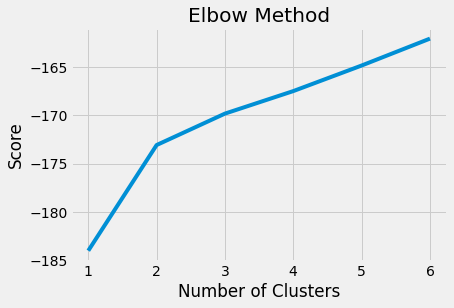

In [12]:
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

### 3.2 Evaluting the optimal number of clusters
On the last step we saw how after 3 cluster the improving in score slows down how much it changes.
Let's choose 3 then.

In [13]:
%%time
kmeans = KMeans(3)
kmeans.fit(vectorized_docs)
kmeans_df = sample_df.copy()
kmeans_df['cluster_label'] = [label for label in kmeans.labels_]
kmeans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1982 to 1213
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  200 non-null    object
 1   process_id     200 non-null    object
 2   doc_id         200 non-null    object
 3   path_img       200 non-null    object
 4   text           200 non-null    object
 5   doc_type       200 non-null    object
 6   num_pag        200 non-null    int64 
 7   cluster_label  200 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 14.1+ KB
CPU times: user 14 s, sys: 9 s, total: 23 s
Wall time: 8.32 s


In [20]:
sklearn_SVD = TruncatedSVD(n_components = 2)
svd_docs = sklearn_SVD.fit_transform(vectorized_docs)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(svd_docs)
prediction = kmeans.predict(svd_docs)

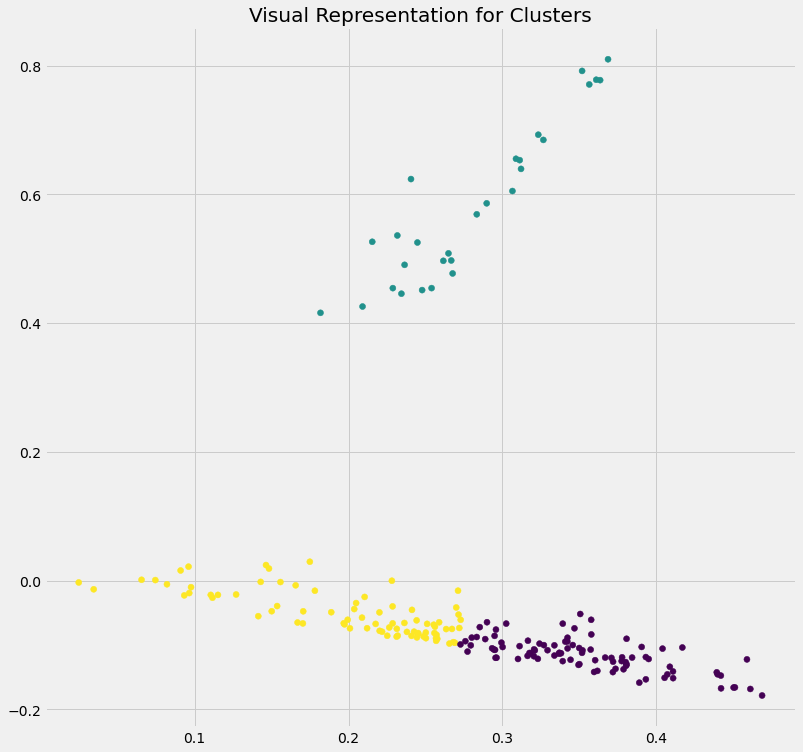

In [29]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(pca_docs[:, 0], pca_docs[:, 1], c=prediction)
plt.title("Visual Representation for Clusters")

plt.show()

In [14]:
kmeans_df.head()

,process_class,process_id,doc_id,path_img,text,doc_type,num_pag,cluster_label
1982,ARE,827044,4916937,[b'./processos_imgs/acordao_de_2_instancia_pur...,ESTADO DO RIO DE JANEIRO\nPODER JUDICIÁRIO\n\...,acordao_de_2_instancia_puro,5,0
1562,RE,1138645,314557527,[./processos_imgs/sentenca_puro/RE_1138645_314...,"recurso. Vencidos, no ponto, os Ministros Cár...",sentenca_puro,9,2
1921,ARE,1062730,312269232,[b'./processos_imgs/agravo_em_recurso_extraord...,ga ESTADO DE SANTA CATARINA\nPROCURADORIA GER...,agravo_em_recurso_extraordinario_puro,13,0
1311,ARE,823578,4828115,[./processos_imgs/sentenca_puro/ARE_823578_482...,ESTADO DE SANTA CATARINA\nPODER JUDICIÁRIO\n\...,sentenca_puro,10,2
727,ARE,787966,5845285,[./processos_imgs/outros_puro/ARE_787966_58452...,PÁGINA DE SEPARAÇÃO\n(Gerada automaticamente ...,outros_puro,1,1


## 4. Bibliography
K-Means Clustering. Daniel Furlay. [Avaiablae at](https://towardsdatascience.com/k-means-clustering-8e1e64c1561c) Last visited: 16/04/2020 